<a href="https://colab.research.google.com/github/Panshark/SBAQ_simulate/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm, trange
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

df_inter = pd.read_table('./sd02.txt',header = None)
df_char = pd.read_table('./sd03.txt',header = None)

FileNotFoundError: ignored

In [ ]:
df_inter

,0,1,2
0,4,436,1
1,4,590,2
2,4,484,1
3,4,615,1
4,4,325,3
...,...,...,...
762863,406,673,1
762864,406,673,8
762865,406,673,2
762866,406,673,6


In [ ]:
df_char

,0,1
0,4,student
1,476,student
2,481,student
3,436,staff
4,590,student
...,...,...
796,477,staff
797,69,teacher
798,406,staff
799,185,student


In [ ]:
G_base = np.full((df_char.shape[0],df_char.shape[0]),0)

for i in trange(df_inter.shape[0]):
  G_base[df_inter[0][i]][df_inter[1][i]]+=df_inter[2][i]

100%|██████████| 762868/762868 [00:17<00:00, 42437.06it/s]


In [ ]:
Same_num = 0

for i in range(G_base.shape[0]):
  for j in range(G_base.shape[1]):
    if G_base[i][j]==G_base[j][i] and G_base[i][j]!=0:
      # print(G_base[i][j],G_base[j][i])
      Same_num+=1

if Same_num == 0:
  print("Can be Symetric")
else:
  print("Can Not be Symetric")

Can be Symetric


In [ ]:
# symmetrization

if Same_num == 0:
  for i in range(df_inter.shape[0]):
    G_temp = max(G_base[df_inter[1][i]][df_inter[0][i]],G_base[df_inter[0][i]][df_inter[1][i]])
    G_base[df_inter[1][i]][df_inter[0][i]] = G_temp
    G_base[df_inter[0][i]][df_inter[1][i]] = G_temp

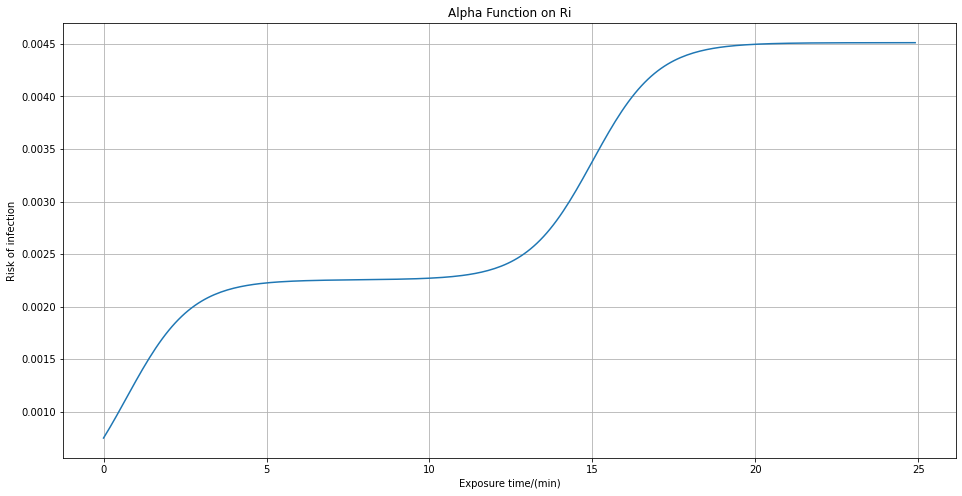

In [ ]:
"""
 From https://www.nyc.gov/site/doh/covid/covid-19-data.page, by Case rate (7-day rate per 100,000 people), infection risk might be 0.0022558:
 From https://www.cdc.gov/coronavirus/2019-ncov/your-health/risks-exposure.html, exposure time threshold is 3min (contact threshold) and 15min (high risk threshold), and https://www.frontiersin.org/articles/10.3389/fmed.2021.664297/full shows longer exposure time could increase infection risk.
 We create an alpha function describing the coefficient of Ri_base according to the exposure time.
"""
def Alpha_rate(T, Ri_base=0.0022558):
  MET = 3
  LET = 15

  alpha = 1 / (1+np.exp(-T+LET))+10 / (10+np.exp(-T+MET))
  Ri = alpha * Ri_base
  return Ri

x = np.arange(0, 25, 0.1)
 
y = Alpha_rate(x)

plt.figure(figsize=(16, 8))
 
plt.title("Alpha Function on Ri")
plt.ylabel("Risk of infection")
plt.xlabel("Exposure time/(min)")
plt.plot(x, y, label="risk")
plt.grid()

plt.show()

#Grid Search

In [ ]:
# Reset the patients status
potential_list = np.where(sum(G_base)>0)[0]
B_isolate = np.where(sum(G_base)==0)[0]
T_list = np.where(sum(G_base)>=0)[0]

sample_num = 1 

sample_list = [i for i in range(len(potential_list))] 
patient_zero = random.sample(sample_list, sample_num)

G_disease = np.full((1,df_char.shape[0]),0)[0]
G_disease[patient_zero] = 1
patient_list = np.where(G_disease>0)[0]

print(patient_list)

[654]


In [ ]:
# Covid-19 simulating without isolating
TIME = 30 #Days
patients_num = len(patient_list)
print("Start simulating, Day 0, we have patients:", patients_num)

for days in trange(TIME):
  G_contact = np.full(G_base.shape,0)
  for p in potential_list:
    # 
    for op in potential_list:
      if (op>=p):
        t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
        t_interaction = max(0,t_interaction)
        if (np.where(patient_list == p)[0].size > 0):
          if (np.random.random() <= Alpha_rate(t_interaction) and G_disease[op] == 0):
            G_disease[op] = 1
        elif (np.where(patient_list == op)[0].size > 0):
          if (np.random.random() <= Alpha_rate(t_interaction) and G_disease[p] == 0):
            G_disease[p] = 1
  
  for p in range(len(G_disease)):
    if G_disease[p] > 0:
      G_disease[p] += 1
  patient_list = np.where(G_disease>0)[0]
  
  print('Day {}: we have {} patients, {} cases of new patients'.format(days+1,len(patient_list), len(patient_list)-patients_num) )
  patients_num = len(patient_list)

  if len(patient_list) == len(potential_list):
    print("Everybody in potential list got sick!")
    break

Start simulating, Day 0, we have patients: 1


  3%|▎         | 1/30 [00:03<01:37,  3.37s/it]

Day 1: we have 1 patients, 0 cases of new patients


  7%|▋         | 2/30 [00:06<01:33,  3.35s/it]

Day 2: we have 4 patients, 3 cases of new patients


 10%|█         | 3/30 [00:10<01:31,  3.39s/it]

Day 3: we have 8 patients, 4 cases of new patients


 13%|█▎        | 4/30 [00:13<01:29,  3.43s/it]

Day 4: we have 13 patients, 5 cases of new patients


 17%|█▋        | 5/30 [00:17<01:26,  3.45s/it]

Day 5: we have 29 patients, 16 cases of new patients


 20%|██        | 6/30 [00:20<01:23,  3.47s/it]

Day 6: we have 60 patients, 31 cases of new patients


 23%|██▎       | 7/30 [00:24<01:20,  3.51s/it]

Day 7: we have 116 patients, 56 cases of new patients


 27%|██▋       | 8/30 [00:28<01:19,  3.63s/it]

Day 8: we have 202 patients, 86 cases of new patients


 30%|███       | 9/30 [00:32<01:19,  3.78s/it]

Day 9: we have 325 patients, 123 cases of new patients


 33%|███▎      | 10/30 [00:36<01:20,  4.04s/it]

Day 10: we have 464 patients, 139 cases of new patients


 37%|███▋      | 11/30 [00:42<01:23,  4.40s/it]

Day 11: we have 593 patients, 129 cases of new patients


 40%|████      | 12/30 [00:46<01:20,  4.49s/it]

Day 12: we have 689 patients, 96 cases of new patients


 43%|████▎     | 13/30 [00:51<01:18,  4.60s/it]

Day 13: we have 744 patients, 55 cases of new patients


 47%|████▋     | 14/30 [00:56<01:13,  4.58s/it]

Day 14: we have 769 patients, 25 cases of new patients


 50%|█████     | 15/30 [01:00<01:08,  4.56s/it]

Day 15: we have 780 patients, 11 cases of new patients


 53%|█████▎    | 16/30 [01:05<01:03,  4.56s/it]

Day 16: we have 784 patients, 4 cases of new patients


 53%|█████▎    | 16/30 [01:09<01:01,  4.36s/it]

Day 17: we have 788 patients, 4 cases of new patients
Everybody in potential list got sick!


In [ ]:
# Sampling Graph Data
Sample_size = 50
G_contacts = []

for s in trange(Sample_size):
  G_contact = np.full(G_base.shape,0)
  for p in potential_list:
    # 
    for op in potential_list:
      if (op>=p):
        t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
        t_interaction = max(0,t_interaction)
        if (p==op):
          G_contact[p][op] = 1
        elif t_interaction >= 3:
          G_contact[p][op] = 1
          G_contact[op][p] = 1
  G_contacts.append(G_contact)

100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


In [ ]:
G_1 = G_contacts[0:int(len(G_contacts)/2)]
G_2 = G_contacts[int(len(G_contacts)/2):int(len(G_contacts)/2)*2]

def E_rc(G1,G2,I,J):
  ck_hat = 0
  rk_hat = 0

  for i in range(G1[0].shape[0]):
    ck1 = 0
    ck2 = 0
    rk1 = 0
    rk2 = 0
    for g in range(len(G1)): 
      if i != I:
        ck1 += G1[g][i][I]
        rk1 += G1[g][I][i]
      if i != J:
        ck2 += G2[g][i][J]
        rk2 += G2[g][J][i]
    ck_hat += ck1 * ck2
    rk_hat += rk1 * rk2
  
  return ck_hat/(len(G1)**2*(len(np.delete(T_list, [I,J])))),rk_hat/(len(G1)**2*(len(np.delete(T_list, [I,J]))))

In [ ]:
def Blocking(B_isolate, patient_list, G_1, G_2, Delta=0.43, Block_max=50, gama=0.01):  
  # Reset Blocking
  Delta_squre = Delta ** 2
  patient_list_copy = patient_list
  Blocks = []
  Blocks_delta = []
  Blocks.append(B_isolate)
  Blocks_delta.append(0)

  while(len(patient_list_copy)>0):
    sample_list = [i for i in patient_list_copy] 
    pivot = random.sample(sample_list, 1)[0]
    B_temp = []
    # B_temp.append(pivot)
    # patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == B_temp)[0])
    for j in patient_list_copy:
      c_ij, r_ij = E_rc(G_1,G_2,pivot,j)
      c_ii, r_ii = E_rc(G_1,G_2,pivot,pivot)
      c_jj, r_jj = E_rc(G_1,G_2,j,j)
      d_ij = ( (r_ii-2*r_ij+r_jj)+(c_ii-2*c_ij+c_jj) )/2
      if d_ij<=Delta_squre:
        B_temp.append(j)
    for i in B_temp:
      patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == i)[0])
    Blocks.append(np.array(B_temp))
    Blocks_delta.append(Delta)
    # print('Blocks num {}, remaining nodes {}'.format(len(Blocks),len(patient_list_copy)))
    # break

  while(True):
    Delta -= gama
    for b in range(len(Blocks)):
      if len(Blocks[b]) >= Block_max:
        Delta_squre = Delta ** 2
        patient_list_copy = Blocks[b]
        while(len(patient_list_copy)>Block_max):
          sample_list = [i for i in patient_list_copy] 
          pivot = random.sample(sample_list, 1)[0]
          B_temp = []
          # B_temp.append(pivot)
          # patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == B_temp)[0])
          for j in patient_list_copy:
            c_ij, r_ij = E_rc(G_1,G_2,pivot,j)
            c_ii, r_ii = E_rc(G_1,G_2,pivot,pivot)
            c_jj, r_jj = E_rc(G_1,G_2,j,j)
            d_ij = ( (r_ii-2*r_ij+r_jj)+(c_ii-2*c_ij+c_jj) )/2
            if d_ij<=Delta_squre:
              B_temp.append(j)
          for i in B_temp:
            patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == i)[0])
          Blocks.append(np.array(B_temp))
          Blocks_delta.append(Delta)
          # print('Dividing Huge Blocks uses delta={:.2f} ... Blocks num {}, remaining nodes in divided block {}'.format(Delta,len(Blocks),len(patient_list_copy)))
        if len(patient_list_copy) == 0:
          Blocks.pop(b)
          Blocks_delta.pop(b)
        else:
          Blocks[b] = patient_list_copy

    
    if all([len(Blocks[b]) <= Block_max for b in range(len(Blocks))]):
      print("Finish Blocking!")
      break
  
  return Blocks

In [ ]:
simulate_num = 30
iteration_num = 10
total_days = []
patient_population = []
isolated_population = []

for block_size in trange(25,80,5):
  total_days_inter = []
  patient_population_inter = []
  isolated_population_inter = []
  for iteration in trange(iteration_num):
    Blocks = Blocking(B_isolate, patient_list, G_1, G_2, Delta=0.43, Block_max=block_size, gama=0.01)
    # Reset the patients status
    G_disease_ib = np.full((1,df_char.shape[0]),0)[0]
    G_disease_ib[patient_zero] = 1
    patient_list_ib = np.where(G_disease_ib>0)[0]
    isolate_list_b = []
    potential_list_ib = potential_list
    Block_list = np.array(list(range(len(Blocks))))
    latency = 4

    # Covid-19 simulating with blockwise isolating
    TIME = 30 #Days
    patients_num = len(patient_list_ib)
    print("Start simulating, Day 0, we have patients:", patients_num)

    for days in range(TIME):
      for p in potential_list_ib:
        # if (np.where(isolate_list_b == p)[0].size == 0):
          for op in potential_list_ib:
            # if (np.where(isolate_list_b == op)[0].size == 0) and (op>=p):
            if (op>=p):
              if (np.where(patient_list_ib == p)[0].size > 0):
                t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
                t_interaction = max(0,t_interaction)  
                if (np.random.random() <= Alpha_rate(t_interaction) and G_disease_ib[op] == 0):
                  G_disease_ib[op] = 1
              elif (np.where(patient_list_ib == op)[0].size > 0):
                t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
                t_interaction = max(0,t_interaction)
                if (np.random.random() <= Alpha_rate(t_interaction) and G_disease_ib[p] == 0):
                  G_disease_ib[p] = 1

      for p in range(len(G_disease_ib)):
        if G_disease_ib[p] > 0:
          G_disease_ib[p] += 1
        if (G_disease_ib[p] >= latency) and (np.where(np.array(isolate_list_b) == p)[0].size == 0):
          isolate_list_b.append(p)
          for b in Block_list:
            if np.where(Blocks[b] == p)[0].size >0:
              isolate_list_b.extend(Blocks[b].tolist())
              Block_list = np.delete(Block_list, np.where(Block_list == b)[0])
              break
      patient_list_ib = np.where(G_disease_ib>0)[0]
      # print(isolate_list_b)
      for i in isolate_list_b:
        potential_list_ib = np.delete(potential_list_ib, np.where(potential_list_ib == i)[0])
      
      # print('Day {}: we have {} patients, {} cases of new patients, {} isolated patients'.format(days+1,len(patient_list_ib), len(patient_list_ib)-patients_num, len(isolate_list_b)))
      patients_num = len(patient_list_ib)

      if len(patient_list_ib) == len(potential_list):
        print("Everybody in potential list got sick!")
        total_days_inter.append(days+1)
        patient_population_inter.append(len(patient_list_ib))
        isolated_population_inter.append(len(isolate_list_b))
        break

      if set(patient_list_ib).issubset(isolate_list_b):
        print("Every patients are isolated!")
        total_days_inter.append(days+1)
        patient_population_inter.append(len(patient_list_ib))
        isolated_population_inter.append(len(isolate_list_b))
        break
    np.save('total_days_inter.npy',total_days_inter)
    np.save('patient_population_inter.npy',patient_population_inter)
    np.save('isolated_population_inter',isolated_population_inter)

  total_days.append(total_days_inter)
  patient_population.append(patient_population_inter)
  isolated_population.append(isolated_population_inter)
  np.save('total_days.npy',total_days)
  np.save('patient_population.npy',patient_population)
  np.save('isolated_population',isolated_population)
  
  

  0%|          | 0/10 [00:00<?, ?it/s]

Finish Blocking!
Start simulating, Day 0, we have patients: 1



 10%|█         | 1/10 [16:46<2:31:00, 1006.68s/it]

Every patients are isolated!
Finish Blocking!
Start simulating, Day 0, we have patients: 1



 20%|██        | 2/10 [36:47<2:29:27, 1120.94s/it]

Every patients are isolated!


  0%|          | 0/11 [40:45<?, ?it/s]


KeyboardInterrupt: ignored

#Comparison Experiments

##Pre-processing

In [ ]:
# Reset the patients status
potential_list = np.where(sum(G_base)>0)[0]
B_isolate = np.where(sum(G_base)==0)[0]
T_list = np.where(sum(G_base)>=0)[0]

sample_num = 1 
sample_list = [i for i in range(len(potential_list))] 
patient_zero = random.sample(sample_list, sample_num)

G_disease = np.full((1,df_char.shape[0]),0)[0]
G_disease[patient_zero] = 1
patient_list = np.where(G_disease>0)[0]

print(patient_list)

[538]


In [ ]:
len(potential_list)

788

In [ ]:
# # Contact Graph generating

# from tqdm import tqdm, trange

# for i in trange(3):
#   G_contact = np.full(G_base.shape,0)

In [ ]:
# Covid-19 simulating without isolating
TIME = 30 #Days
patients_num = len(patient_list)
print("Start simulating, Day 0, we have patients:", patients_num)

for days in trange(TIME):
  G_contact = np.full(G_base.shape,0)
  for p in potential_list:
    # 
    for op in potential_list:
      if (op>=p):
        t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
        t_interaction = max(0,t_interaction)
        if (np.where(patient_list == p)[0].size > 0):
          if (np.random.random() <= Alpha_rate(t_interaction) and G_disease[op] == 0):
            G_disease[op] = 1
        elif (np.where(patient_list == op)[0].size > 0):
          if (np.random.random() <= Alpha_rate(t_interaction) and G_disease[p] == 0):
            G_disease[p] = 1
  
  for p in range(len(G_disease)):
    if G_disease[p] > 0:
      G_disease[p] += 1
  patient_list = np.where(G_disease>0)[0]
  
  print('Day {}: we have {} patients, {} cases of new patients'.format(days+1,len(patient_list), len(patient_list)-patients_num) )
  patients_num = len(patient_list)

  if len(patient_list) == len(potential_list):
    print("Everybody in potential list got sick!")
    break

Start simulating, Day 0, we have patients: 1


  3%|▎         | 1/30 [00:03<01:39,  3.42s/it]

Day 1: we have 2 patients, 1 cases of new patients


  7%|▋         | 2/30 [00:06<01:36,  3.44s/it]

Day 2: we have 4 patients, 2 cases of new patients


 10%|█         | 3/30 [00:10<01:32,  3.41s/it]

Day 3: we have 6 patients, 2 cases of new patients


 13%|█▎        | 4/30 [00:13<01:28,  3.40s/it]

Day 4: we have 10 patients, 4 cases of new patients


 17%|█▋        | 5/30 [00:17<01:25,  3.41s/it]

Day 5: we have 17 patients, 7 cases of new patients


 20%|██        | 6/30 [00:20<01:21,  3.41s/it]

Day 6: we have 29 patients, 12 cases of new patients


 23%|██▎       | 7/30 [00:23<01:19,  3.44s/it]

Day 7: we have 55 patients, 26 cases of new patients


 27%|██▋       | 8/30 [00:27<01:16,  3.47s/it]

Day 8: we have 93 patients, 38 cases of new patients


 30%|███       | 9/30 [00:31<01:14,  3.54s/it]

Day 9: we have 163 patients, 70 cases of new patients


 33%|███▎      | 10/30 [00:35<01:12,  3.63s/it]

Day 10: we have 270 patients, 107 cases of new patients


 37%|███▋      | 11/30 [00:39<01:12,  3.81s/it]

Day 11: we have 420 patients, 150 cases of new patients


 40%|████      | 12/30 [00:43<01:10,  3.93s/it]

Day 12: we have 574 patients, 154 cases of new patients


 43%|████▎     | 13/30 [00:47<01:09,  4.10s/it]

Day 13: we have 667 patients, 93 cases of new patients


 47%|████▋     | 14/30 [00:52<01:06,  4.19s/it]

Day 14: we have 733 patients, 66 cases of new patients


 50%|█████     | 15/30 [00:57<01:04,  4.33s/it]

Day 15: we have 768 patients, 35 cases of new patients


 53%|█████▎    | 16/30 [01:01<01:00,  4.35s/it]

Day 16: we have 779 patients, 11 cases of new patients


 57%|█████▋    | 17/30 [01:05<00:56,  4.35s/it]

Day 17: we have 783 patients, 4 cases of new patients


 60%|██████    | 18/30 [01:10<00:52,  4.36s/it]

Day 18: we have 785 patients, 2 cases of new patients


 63%|██████▎   | 19/30 [01:14<00:47,  4.34s/it]

Day 19: we have 786 patients, 1 cases of new patients


 67%|██████▋   | 20/30 [01:18<00:43,  4.34s/it]

Day 20: we have 787 patients, 1 cases of new patients


 70%|███████   | 21/30 [01:23<00:38,  4.33s/it]

Day 21: we have 787 patients, 0 cases of new patients


 73%|███████▎  | 22/30 [01:27<00:34,  4.34s/it]

Day 22: we have 787 patients, 0 cases of new patients


 77%|███████▋  | 23/30 [01:31<00:30,  4.35s/it]

Day 23: we have 787 patients, 0 cases of new patients


 80%|████████  | 24/30 [01:36<00:26,  4.49s/it]

Day 24: we have 787 patients, 0 cases of new patients


 83%|████████▎ | 25/30 [01:40<00:22,  4.46s/it]

Day 25: we have 787 patients, 0 cases of new patients


 87%|████████▋ | 26/30 [01:45<00:18,  4.55s/it]

Day 26: we have 787 patients, 0 cases of new patients


 90%|█████████ | 27/30 [01:50<00:13,  4.51s/it]

Day 27: we have 787 patients, 0 cases of new patients


 93%|█████████▎| 28/30 [01:54<00:08,  4.47s/it]

Day 28: we have 787 patients, 0 cases of new patients


 97%|█████████▋| 29/30 [01:58<00:04,  4.44s/it]

Day 29: we have 787 patients, 0 cases of new patients


 97%|█████████▋| 29/30 [02:03<00:04,  4.25s/it]

Day 30: we have 788 patients, 1 cases of new patients
Everybody in potential list got sick!


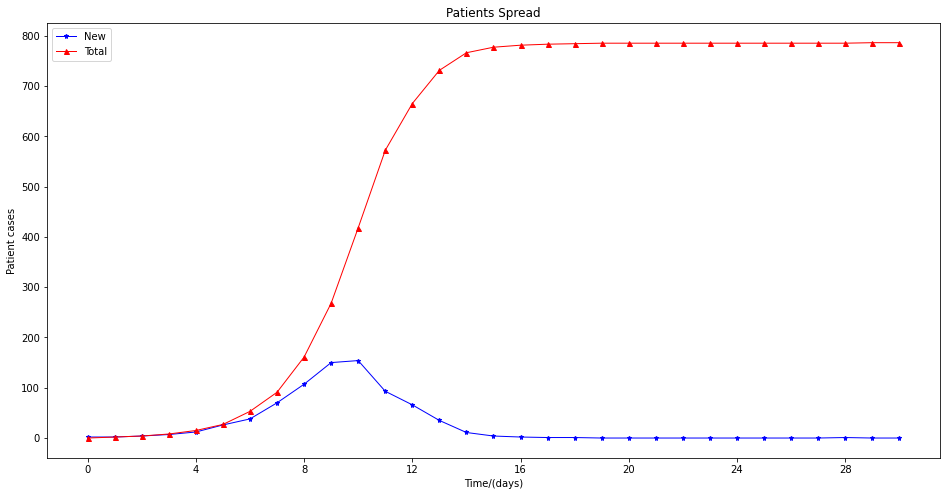

In [ ]:
D_time = max(G_disease)
x = np.arange(0, D_time, 1)
y = np.zeros(x.shape)
z = np.zeros(x.shape)

for i in x:
  if i == D_time-1:
    y[i]=0
  else:
    y[i] = np.where(G_disease == (D_time-x[i]-1))[0].size
for i in x:
  z[i] = sum(y[0:i])

plt.figure(figsize=(16, 8))

plt.title("Patients Spread")
plt.ylabel("Patient cases")
plt.xlabel("Time/(days)")
plt.plot(x, y, label="New", linewidth=1, color='b', marker='*',
         markerfacecolor='blue', markersize=5)
plt.plot(x, z, label="Total", linewidth=1, color='r', marker='^',
         markerfacecolor='red', markersize=5)

# for a,b in zip(x,y):
#     plt.text(a, b, '%d' % b, ha='center', va= 'bottom',fontsize=9)
# for a,b in zip(x,z):
#     plt.text(a, b, '%d' % b, ha='center', va= 'bottom',fontsize=9)
    
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [ ]:
# Sampling Graph Data
Sample_size = 50
G_contacts = []

for s in trange(Sample_size):
  G_contact = np.full(G_base.shape,0)
  for p in potential_list:
    # 
    for op in potential_list:
      if (op>=p):
        t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
        t_interaction = max(0,t_interaction)
        if (p==op):
          G_contact[p][op] = 1
        elif t_interaction >= 3:
          G_contact[p][op] = 1
          G_contact[op][p] = 1
  G_contacts.append(G_contact)

100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


In [ ]:
len(G_contacts)

50

In [ ]:
G_1 = G_contacts[0:int(len(G_contacts)/2)]
G_2 = G_contacts[int(len(G_contacts)/2):int(len(G_contacts)/2)*2]

def E_rc(G1,G2,I,J):
  ck_hat = 0
  rk_hat = 0

  for i in range(G1[0].shape[0]):
    ck1 = 0
    ck2 = 0
    rk1 = 0
    rk2 = 0
    for g in range(len(G1)): 
      if i != I:
        ck1 += G1[g][i][I]
        rk1 += G1[g][I][i]
      if i != J:
        ck2 += G2[g][i][J]
        rk2 += G2[g][J][i]
    ck_hat += ck1 * ck2
    rk_hat += rk1 * rk2
  
  return ck_hat/(len(G1)**2*(len(np.delete(T_list, [I,J])))),rk_hat/(len(G1)**2*(len(np.delete(T_list, [I,J]))))

In [ ]:
E_rc(G_1,G_2,1,2)

(0.0025031289111389237, 0.0025031289111389237)

##Blocking

In [ ]:
# Reset Blocking
Delta = 0.43
Delta_squre = Delta ** 2
patient_list_copy = patient_list
Blocks = []
Blocks_delta = []
Blocks.append(B_isolate)
Blocks_delta.append(0)

Block_max = 50
gama = 0.01

In [ ]:
# Blockwise
while(len(patient_list_copy)>0):
  sample_list = [i for i in patient_list_copy] 
  pivot = random.sample(sample_list, 1)[0]
  B_temp = []
  # B_temp.append(pivot)
  # patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == B_temp)[0])
  for j in patient_list_copy:
    c_ij, r_ij = E_rc(G_1,G_2,pivot,j)
    c_ii, r_ii = E_rc(G_1,G_2,pivot,pivot)
    c_jj, r_jj = E_rc(G_1,G_2,j,j)
    d_ij = ( (r_ii-2*r_ij+r_jj)+(c_ii-2*c_ij+c_jj) )/2
    if d_ij<=Delta_squre:
      B_temp.append(j)
  for i in B_temp:
    patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == i)[0])
  Blocks.append(np.array(B_temp))
  Blocks_delta.append(Delta)
  print('Blocks num {}, remaining nodes {}'.format(len(Blocks),len(patient_list_copy)))
  # break

while(True):
  Delta -= gama
  for b in range(len(Blocks)):
    if len(Blocks[b]) >= Block_max:
      Delta_squre = Delta ** 2
      patient_list_copy = Blocks[b]
      while(len(patient_list_copy)>Block_max):
        sample_list = [i for i in patient_list_copy] 
        pivot = random.sample(sample_list, 1)[0]
        B_temp = []
        # B_temp.append(pivot)
        # patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == B_temp)[0])
        for j in patient_list_copy:
          c_ij, r_ij = E_rc(G_1,G_2,pivot,j)
          c_ii, r_ii = E_rc(G_1,G_2,pivot,pivot)
          c_jj, r_jj = E_rc(G_1,G_2,j,j)
          d_ij = ( (r_ii-2*r_ij+r_jj)+(c_ii-2*c_ij+c_jj) )/2
          if d_ij<=Delta_squre:
            B_temp.append(j)
        for i in B_temp:
          patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == i)[0])
        Blocks.append(np.array(B_temp))
        Blocks_delta.append(Delta)
        print('Dividing Huge Blocks uses delta={:.2f} ... Blocks num {}, remaining nodes in divided block {}'.format(Delta,len(Blocks),len(patient_list_copy)))
      if len(patient_list_copy) == 0:
        Blocks.pop(b)
        Blocks_delta.pop(b)
      else:
        Blocks[b] = patient_list_copy

  
  if all([len(Blocks[b]) <= Block_max for b in range(len(Blocks))]):
    break

Blocks num 2, remaining nodes 182
Blocks num 3, remaining nodes 128
Blocks num 4, remaining nodes 91
Blocks num 5, remaining nodes 63
Blocks num 6, remaining nodes 34
Blocks num 7, remaining nodes 33
Blocks num 8, remaining nodes 30
Blocks num 9, remaining nodes 25
Blocks num 10, remaining nodes 13
Blocks num 11, remaining nodes 12
Blocks num 12, remaining nodes 11
Blocks num 13, remaining nodes 10
Blocks num 14, remaining nodes 7
Blocks num 15, remaining nodes 4
Blocks num 16, remaining nodes 3
Blocks num 17, remaining nodes 2
Blocks num 18, remaining nodes 1
Blocks num 19, remaining nodes 0
Dividing Huge Blocks uses delta=0.42 ... Blocks num 20, remaining nodes in divided block 16
Dividing Huge Blocks uses delta=0.42 ... Blocks num 21, remaining nodes in divided block 33
Dividing Huge Blocks uses delta=0.41 ... Blocks num 22, remaining nodes in divided block 322
Dividing Huge Blocks uses delta=0.41 ... Blocks num 23, remaining nodes in divided block 163
Dividing Huge Blocks uses delt

In [ ]:
len(Blocks)

50

In [ ]:
all([len(Blocks[b]) <= Block_max for b in range(len(Blocks))])

True

In [ ]:
print(Blocks)
print(Blocks_delta)

[array([  0, 548, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800]), array([133, 221, 261, 381, 414, 421, 428, 460, 479, 498, 590, 620, 633,
       642, 676, 770]), array([ 30,  33,  54,  99, 111, 175, 177, 226, 244, 250, 299, 304, 380,
       386, 392, 398, 434, 462, 480, 495, 500, 511, 525, 527, 531, 551,
       579, 587, 589, 666, 738, 759, 767]), array([  2,  10,  19,  22,  23, 101, 102, 110, 112, 126, 127, 160, 168,
       208, 223, 230, 295, 300, 331, 373, 385, 395, 422, 468, 476, 504,
       513, 532, 583, 592, 597, 632, 650, 685, 687, 692, 737]), array([ 24,  32,  45, 121, 143, 145, 148, 167, 170, 236, 248, 252, 279,
       291, 318, 382, 446, 554, 581, 646, 655, 671, 672, 684, 708, 717,
       732, 777]), array([ 29,  67,  75,  84, 119, 130, 219, 227, 264, 265, 354, 355, 360,
       391, 403, 487, 515, 534, 535, 538, 541, 547, 593, 614, 625, 629,
       682, 758, 782]), array([74]), array([307, 399, 703]), array([329, 419, 574, 648, 724]), array([ 63,  70, 196, 206, 224,

##Simulating

###With single isolating

In [ ]:
# Reset the patients status
G_disease_i = np.full((1,df_char.shape[0]),0)[0]
G_disease_i[patient_zero] = 1
patient_list_i = np.where(G_disease_i>0)[0]
isolate_list = []
potential_list_i = potential_list
latency = 4

print(patient_list_i)

[538]


In [ ]:
# Covid-19 simulating with isolating
TIME = 30 #Days
patients_num = len(patient_list_i)
print("Start simulating, Day 0, we have patients:", patients_num)

for days in trange(TIME):
  for p in potential_list_i:
    # if (np.where(isolate_list == p)[0].size == 0):
      for op in potential_list_i:
        # if (np.where(isolate_list == op)[0].size == 0) and (op>=p):
        if (op>=p):
          if (np.where(patient_list_i == p)[0].size > 0):
            t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
            t_interaction = max(0,t_interaction)  
            if (np.random.random() <= Alpha_rate(t_interaction) and G_disease_i[op] == 0):
              G_disease_i[op] = 1
          elif (np.where(patient_list_i == op)[0].size > 0):
            t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
            t_interaction = max(0,t_interaction)
            if (np.random.random() <= Alpha_rate(t_interaction) and G_disease_i[p] == 0):
              G_disease_i[p] = 1

  for p in range(len(G_disease_i)):
    if G_disease_i[p] > 0:
      G_disease_i[p] += 1
    if (G_disease_i[p] >= latency) and (np.where(np.array(isolate_list) == p)[0].size == 0):
      isolate_list.append(p)
  patient_list_i = np.where(G_disease_i>0)[0]
  # print(isolate_list)
  for i in isolate_list:
    potential_list_i = np.delete(potential_list_i, np.where(potential_list_i == i)[0])
  
  print('Day {}: we have {} patients, {} cases of new patients, {} isolated patients'.format(days+1,len(patient_list_i), len(patient_list_i)-patients_num, len(isolate_list)))
  patients_num = len(patient_list_i)

  if len(patient_list_i) == len(potential_list):
    print("Everybody in potential list got sick!")
    break

  if set(patient_list_i).issubset(isolate_list):
    print("Every patients are isolated!")
    break

Start simulating, Day 0, we have patients: 1


  3%|▎         | 1/30 [00:02<01:03,  2.19s/it]

Day 1: we have 4 patients, 3 cases of new patients, 0 isolated patients


  7%|▋         | 2/30 [00:05<01:19,  2.85s/it]

Day 2: we have 8 patients, 4 cases of new patients, 0 isolated patients


 10%|█         | 3/30 [00:08<01:21,  3.04s/it]

Day 3: we have 20 patients, 12 cases of new patients, 4 isolated patients


 13%|█▎        | 4/30 [00:10<01:06,  2.55s/it]

Day 4: we have 41 patients, 21 cases of new patients, 8 isolated patients


 17%|█▋        | 5/30 [00:12<00:58,  2.32s/it]

Day 5: we have 66 patients, 25 cases of new patients, 20 isolated patients


 20%|██        | 6/30 [00:14<00:52,  2.20s/it]

Day 6: we have 106 patients, 40 cases of new patients, 41 isolated patients


 23%|██▎       | 7/30 [00:16<00:49,  2.13s/it]

Day 7: we have 152 patients, 46 cases of new patients, 66 isolated patients


 27%|██▋       | 8/30 [00:18<00:45,  2.09s/it]

Day 8: we have 217 patients, 65 cases of new patients, 106 isolated patients


 30%|███       | 9/30 [00:20<00:43,  2.05s/it]

Day 9: we have 276 patients, 59 cases of new patients, 152 isolated patients


 33%|███▎      | 10/30 [00:22<00:39,  1.99s/it]

Day 10: we have 343 patients, 67 cases of new patients, 217 isolated patients


 37%|███▋      | 11/30 [00:23<00:35,  1.85s/it]

Day 11: we have 401 patients, 58 cases of new patients, 276 isolated patients


 40%|████      | 12/30 [00:25<00:30,  1.69s/it]

Day 12: we have 452 patients, 51 cases of new patients, 343 isolated patients


 43%|████▎     | 13/30 [00:26<00:25,  1.49s/it]

Day 13: we have 489 patients, 37 cases of new patients, 401 isolated patients


 47%|████▋     | 14/30 [00:26<00:20,  1.26s/it]

Day 14: we have 522 patients, 33 cases of new patients, 452 isolated patients


 50%|█████     | 15/30 [00:27<00:16,  1.08s/it]

Day 15: we have 540 patients, 18 cases of new patients, 489 isolated patients


 53%|█████▎    | 16/30 [00:28<00:12,  1.11it/s]

Day 16: we have 558 patients, 18 cases of new patients, 522 isolated patients


 57%|█████▋    | 17/30 [00:28<00:09,  1.35it/s]

Day 17: we have 570 patients, 12 cases of new patients, 540 isolated patients


 60%|██████    | 18/30 [00:28<00:07,  1.62it/s]

Day 18: we have 574 patients, 4 cases of new patients, 558 isolated patients


 63%|██████▎   | 19/30 [00:28<00:05,  1.96it/s]

Day 19: we have 581 patients, 7 cases of new patients, 570 isolated patients


 67%|██████▋   | 20/30 [00:29<00:04,  2.34it/s]

Day 20: we have 582 patients, 1 cases of new patients, 574 isolated patients


 73%|███████▎  | 22/30 [00:29<00:02,  3.20it/s]

Day 21: we have 583 patients, 1 cases of new patients, 581 isolated patients
Day 22: we have 584 patients, 1 cases of new patients, 582 isolated patients


 77%|███████▋  | 23/30 [00:30<00:09,  1.30s/it]

Day 23: we have 584 patients, 0 cases of new patients, 583 isolated patients
Day 24: we have 584 patients, 0 cases of new patients, 584 isolated patients
Every patients are isolated!


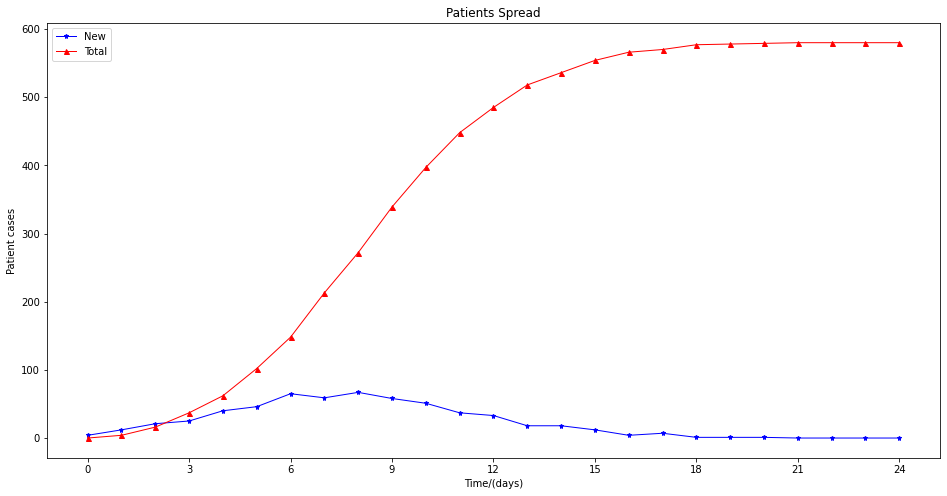

In [ ]:
D_time = max(G_disease_i)
x = np.arange(0, D_time, 1)
y = np.zeros(x.shape)
z = np.zeros(x.shape)

for i in x:
  if i == D_time-1:
    y[i]=0
  else:
    y[i] = np.where(G_disease_i == (D_time-x[i]-1))[0].size
for i in x:
  z[i] = sum(y[0:i])

plt.figure(figsize=(16, 8))

plt.title("Patients Spread")
plt.ylabel("Patient cases")
plt.xlabel("Time/(days)")
plt.plot(x, y, label="New", linewidth=1, color='b', marker='*',
         markerfacecolor='blue', markersize=5)
plt.plot(x, z, label="Total", linewidth=1, color='r', marker='^',
         markerfacecolor='red', markersize=5)

# for a,b in zip(x,y):
#     plt.text(a, b, '%d' % b, ha='center', va= 'bottom',fontsize=9)
# for a,b in zip(x,z):
#     plt.text(a, b, '%d' % b, ha='center', va= 'bottom',fontsize=9)
    
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

###With Blockwise isolating

In [ ]:
# Reset the patients status
G_disease_ib = np.full((1,df_char.shape[0]),0)[0]
G_disease_ib[patient_zero] = 1
patient_list_ib = np.where(G_disease_ib>0)[0]
isolate_list_b = []
potential_list_ib = potential_list
Block_list = np.array(list(range(len(Blocks))))
latency = 4

print(patient_list_ib)

[538]


In [ ]:
# Covid-19 simulating with blockwise isolating
TIME = 30 #Days
patients_num = len(patient_list_ib)
print("Start simulating, Day 0, we have patients:", patients_num)

for days in trange(TIME):
  for p in potential_list_ib:
    # if (np.where(isolate_list_b == p)[0].size == 0):
      for op in potential_list_ib:
        # if (np.where(isolate_list_b == op)[0].size == 0) and (op>=p):
        if (op>=p):
          if (np.where(patient_list_ib == p)[0].size > 0):
            t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
            t_interaction = max(0,t_interaction)  
            if (np.random.random() <= Alpha_rate(t_interaction) and G_disease_ib[op] == 0):
              G_disease_ib[op] = 1
          elif (np.where(patient_list_ib == op)[0].size > 0):
            t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
            t_interaction = max(0,t_interaction)
            if (np.random.random() <= Alpha_rate(t_interaction) and G_disease_ib[p] == 0):
              G_disease_ib[p] = 1

  for p in range(len(G_disease_ib)):
    if G_disease_ib[p] > 0:
      G_disease_ib[p] += 1
    if (G_disease_ib[p] >= latency) and (np.where(np.array(isolate_list_b) == p)[0].size == 0):
      isolate_list_b.append(p)
      for b in Block_list:
        if np.where(Blocks[b] == p)[0].size >0:
          isolate_list_b.extend(Blocks[b].tolist())
          Block_list = np.delete(Block_list, np.where(Block_list == b)[0])
          break
  patient_list_ib = np.where(G_disease_ib>0)[0]
  # print(isolate_list_b)
  for i in isolate_list_b:
    potential_list_ib = np.delete(potential_list_ib, np.where(potential_list_ib == i)[0])
  
  print('Day {}: we have {} patients, {} cases of new patients, {} isolated patients'.format(days+1,len(patient_list_ib), len(patient_list_ib)-patients_num, len(isolate_list_b)))
  patients_num = len(patient_list_ib)

  if len(patient_list_ib) == len(potential_list):
    print("Everybody in potential list got sick!")
    break

  if set(patient_list_ib).issubset(isolate_list_b):
    print("Every patients are isolated!")
    break

Start simulating, Day 0, we have patients: 1


  3%|▎         | 1/30 [00:01<00:52,  1.80s/it]

Day 1: we have 2 patients, 1 cases of new patients, 0 isolated patients


  7%|▋         | 2/30 [00:03<00:49,  1.77s/it]

Day 2: we have 3 patients, 1 cases of new patients, 0 isolated patients


 10%|█         | 3/30 [00:05<00:47,  1.75s/it]

Day 3: we have 4 patients, 1 cases of new patients, 52 isolated patients


 13%|█▎        | 4/30 [00:06<00:43,  1.66s/it]

Day 4: we have 5 patients, 1 cases of new patients, 90 isolated patients


 17%|█▋        | 5/30 [00:08<00:39,  1.57s/it]

Day 5: we have 6 patients, 1 cases of new patients, 128 isolated patients


 20%|██        | 6/30 [00:09<00:35,  1.46s/it]

Day 6: we have 6 patients, 0 cases of new patients, 175 isolated patients


 23%|██▎       | 7/30 [00:10<00:30,  1.34s/it]

Day 7: we have 7 patients, 1 cases of new patients, 207 isolated patients


 27%|██▋       | 8/30 [00:11<00:26,  1.22s/it]

Day 8: we have 8 patients, 1 cases of new patients, 207 isolated patients


 30%|███       | 9/30 [00:12<00:24,  1.15s/it]

Day 9: we have 8 patients, 0 cases of new patients, 220 isolated patients


 30%|███       | 9/30 [00:13<00:31,  1.49s/it]

Day 10: we have 8 patients, 0 cases of new patients, 245 isolated patients
Every patients are isolated!


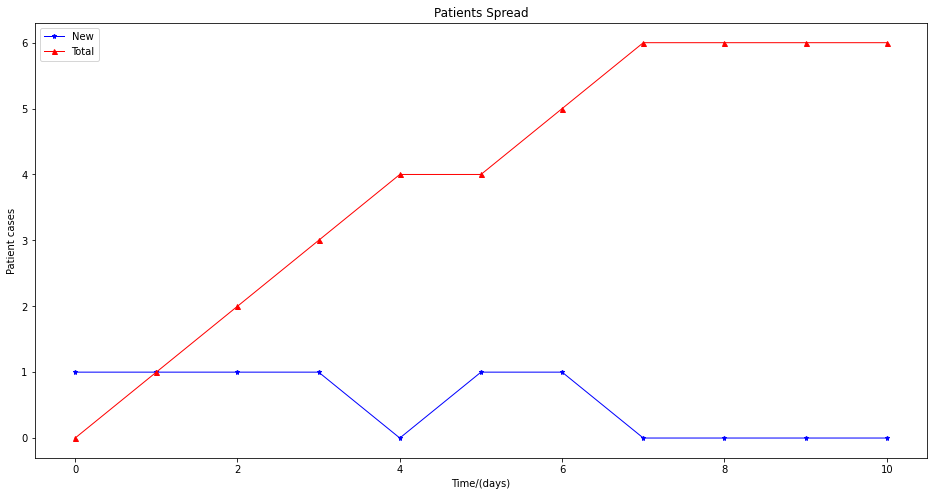

In [ ]:
D_time = max(G_disease_ib)
x = np.arange(0, D_time, 1)
y = np.zeros(x.shape)
z = np.zeros(x.shape)

for i in x:
  if i == D_time-1:
    y[i]=0
  else:
    y[i] = np.where(G_disease_ib == (D_time-x[i]-1))[0].size
for i in x:
  z[i] = sum(y[0:i])

plt.figure(figsize=(16, 8))

plt.title("Patients Spread")
plt.ylabel("Patient cases")
plt.xlabel("Time/(days)")
plt.plot(x, y, label="New", linewidth=1, color='b', marker='*',
         markerfacecolor='blue', markersize=5)
plt.plot(x, z, label="Total", linewidth=1, color='r', marker='^',
         markerfacecolor='red', markersize=5)

# for a,b in zip(x,y):
#     plt.text(a, b, '%d' % b, ha='center', va= 'bottom',fontsize=9)
# for a,b in zip(x,z):
#     plt.text(a, b, '%d' % b, ha='center', va= 'bottom',fontsize=9)
    
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

###With random isolating

In [ ]:
# Reset Blocking
patient_list_copy = patient_list
Blocks_random = []
Blocks.append(B_isolate)

In [ ]:
# Blockwise
while(len(patient_list_copy)>0):
  sample_num = random.randint(1,Block_max)
  sample_list = [i for i in range(len(patient_list_copy))] 
  B_temp = patient_list_copy[random.sample(sample_list, min(len(patient_list_copy),sample_num))]
  for i in B_temp:
    patient_list_copy = np.delete(patient_list_copy, np.where(patient_list_copy == i)[0])
  Blocks_random.append(B_temp)
  print('Blocks num {}, remaining nodes {}'.format(len(Blocks_random),len(patient_list_copy)))
  # break

Blocks num 1, remaining nodes 764
Blocks num 2, remaining nodes 761
Blocks num 3, remaining nodes 746
Blocks num 4, remaining nodes 703
Blocks num 5, remaining nodes 678
Blocks num 6, remaining nodes 657
Blocks num 7, remaining nodes 616
Blocks num 8, remaining nodes 587
Blocks num 9, remaining nodes 555
Blocks num 10, remaining nodes 543
Blocks num 11, remaining nodes 494
Blocks num 12, remaining nodes 453
Blocks num 13, remaining nodes 441
Blocks num 14, remaining nodes 408
Blocks num 15, remaining nodes 391
Blocks num 16, remaining nodes 372
Blocks num 17, remaining nodes 353
Blocks num 18, remaining nodes 303
Blocks num 19, remaining nodes 297
Blocks num 20, remaining nodes 296
Blocks num 21, remaining nodes 272
Blocks num 22, remaining nodes 236
Blocks num 23, remaining nodes 203
Blocks num 24, remaining nodes 197
Blocks num 25, remaining nodes 172
Blocks num 26, remaining nodes 151
Blocks num 27, remaining nodes 107
Blocks num 28, remaining nodes 63
Blocks num 29, remaining nodes

In [ ]:
len(Blocks_random)

30

In [ ]:
print(Blocks_random)

[array([780, 486, 649, 517, 774, 595,  12, 451, 732, 353, 464, 338, 734,
       559, 604, 224, 431,  49, 159, 781, 693,  68,  55, 336]), array([574, 241, 599]), array([423, 514, 149, 355, 374, 158, 766, 518, 408, 443, 491, 711,  54,
       112, 643]), array([516, 562, 150, 182,  60, 742, 703, 748, 476, 337, 775, 687, 745,
       738, 740, 192,  95, 605, 120, 105, 768, 568, 284,   1, 389, 210,
       319, 495, 657, 382, 636, 772, 561, 767, 215, 577, 542, 449, 480,
       138, 226, 579, 269]), array([403, 751, 154,  16, 360,  14, 655,  86, 501, 102, 185, 183, 492,
        53, 515, 393, 433, 321, 528, 252, 200, 108, 537,  10, 728]), array([667, 394, 246, 217,  64, 588, 194, 191, 565, 435, 634, 354, 323,
       155, 446, 586, 181, 508, 557, 730, 465]), array([583, 526, 100, 662, 223, 560, 296, 348, 506, 104,  91, 235, 472,
       695, 645, 406, 741, 434,  28, 661, 278,  98, 281, 220,  37, 297,
       702, 140, 546,  24, 166, 593, 116,  93,  22, 271, 437, 483, 664,
       761, 125]), array(

In [ ]:
# Reset the patients status
G_disease_ib = np.full((1,df_char.shape[0]),0)[0]
G_disease_ib[patient_zero] = 1
patient_list_ib = np.where(G_disease_ib>0)[0]
isolate_list_b = []
potential_list_ib = potential_list
Block_list = np.array(list(range(len(Blocks_random))))
latency = 4

print(patient_list_ib)

[538]


In [ ]:
# Covid-19 simulating with blockwise isolating random
TIME = 30 #Days
patients_num = len(patient_list_ib)
print("Start simulating, Day 0, we have patients:", patients_num)

for days in trange(TIME):
  for p in potential_list_ib:
    # if (np.where(isolate_list_b == p)[0].size == 0):
      for op in potential_list_ib:
        # if (np.where(isolate_list_b == op)[0].size == 0) and (op>=p):
        if (op>=p):
          if (np.where(patient_list_ib == p)[0].size > 0):
            t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
            t_interaction = max(0,t_interaction)  
            if (np.random.random() <= Alpha_rate(t_interaction) and G_disease_ib[op] == 0):
              G_disease_ib[op] = 1
          elif (np.where(patient_list_ib == op)[0].size > 0):
            t_interaction = np.random.normal(loc=G_base[p][op], scale=1) * 20/60
            t_interaction = max(0,t_interaction)
            if (np.random.random() <= Alpha_rate(t_interaction) and G_disease_ib[p] == 0):
              G_disease_ib[p] = 1

  for p in range(len(G_disease_ib)):
    if G_disease_ib[p] > 0:
      G_disease_ib[p] += 1
    if (G_disease_ib[p] >= latency) and (np.where(np.array(isolate_list_b) == p)[0].size == 0):
      isolate_list_b.append(p)
      for b in Block_list:
        if np.where(Blocks_random[b] == p)[0].size >0:
          isolate_list_b.extend(Blocks_random[b].tolist())
          Block_list = np.delete(Block_list, np.where(Block_list == b)[0])
          break
  patient_list_ib = np.where(G_disease_ib>0)[0]
  # print(isolate_list_b)
  for i in isolate_list_b:
    potential_list_ib = np.delete(potential_list_ib, np.where(potential_list_ib == i)[0])
  
  print('Day {}: we have {} patients, {} cases of new patients, {} isolated patients'.format(days+1,len(patient_list_ib), len(patient_list_ib)-patients_num, len(isolate_list_b)))
  patients_num = len(patient_list_ib)

  if len(patient_list_ib) == len(potential_list):
    print("Everybody in potential list got sick!")
    break

  if set(patient_list_ib).issubset(isolate_list_b):
    print("Every patients are isolated!")
    break

Start simulating, Day 0, we have patients: 1


  3%|▎         | 1/30 [00:01<00:50,  1.74s/it]

Day 1: we have 3 patients, 2 cases of new patients, 0 isolated patients


  7%|▋         | 2/30 [00:03<00:49,  1.75s/it]

Day 2: we have 6 patients, 3 cases of new patients, 0 isolated patients


 10%|█         | 3/30 [00:05<00:47,  1.75s/it]

Day 3: we have 11 patients, 5 cases of new patients, 87 isolated patients


 13%|█▎        | 4/30 [00:06<00:41,  1.62s/it]

Day 4: we have 22 patients, 11 cases of new patients, 133 isolated patients


 17%|█▋        | 5/30 [00:07<00:37,  1.51s/it]

Day 5: we have 34 patients, 12 cases of new patients, 235 isolated patients


 20%|██        | 6/30 [00:08<00:32,  1.34s/it]

Day 6: we have 48 patients, 14 cases of new patients, 490 isolated patients


 23%|██▎       | 7/30 [00:09<00:23,  1.01s/it]

Day 7: we have 54 patients, 6 cases of new patients, 575 isolated patients


 27%|██▋       | 8/30 [00:09<00:26,  1.20s/it]

Day 8: we have 55 patients, 1 cases of new patients, 762 isolated patients
Day 9: we have 55 patients, 0 cases of new patients, 769 isolated patients
Every patients are isolated!


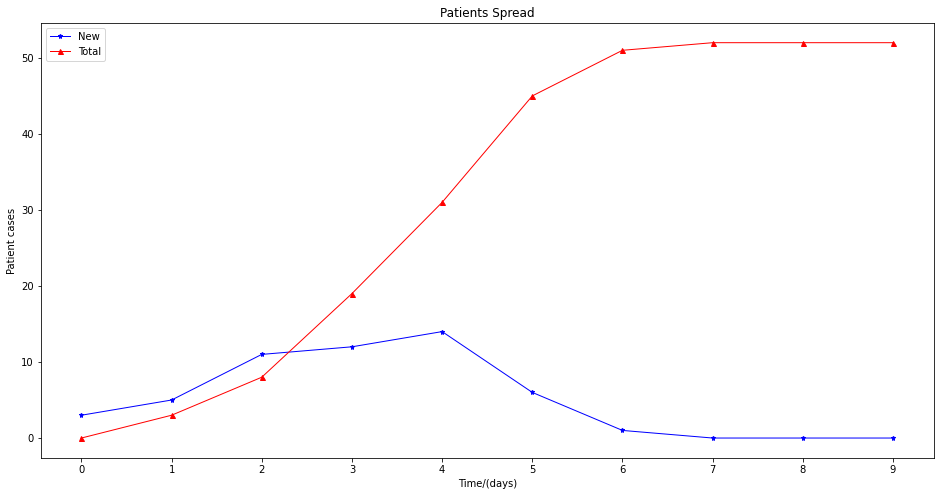

In [ ]:
D_time = max(G_disease_ib)
x = np.arange(0, D_time, 1)
y = np.zeros(x.shape)
z = np.zeros(x.shape)

for i in x:
  if i == D_time-1:
    y[i]=0
  else:
    y[i] = np.where(G_disease_ib == (D_time-x[i]-1))[0].size
for i in x:
  z[i] = sum(y[0:i])

plt.figure(figsize=(16, 8))

plt.title("Patients Spread")
plt.ylabel("Patient cases")
plt.xlabel("Time/(days)")
plt.plot(x, y, label="New", linewidth=1, color='b', marker='*',
         markerfacecolor='blue', markersize=5)
plt.plot(x, z, label="Total", linewidth=1, color='r', marker='^',
         markerfacecolor='red', markersize=5)

# for a,b in zip(x,y):
#     plt.text(a, b, '%d' % b, ha='center', va= 'bottom',fontsize=9)
# for a,b in zip(x,z):
#     plt.text(a, b, '%d' % b, ha='center', va= 'bottom',fontsize=9)
    
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

#Data Processing

In [ ]:
import numpy as np

i = np.load("isolated_population_15.npy")
p = np.load("patient_population_15.npy")
t = np.load("total_days_15.npy")

In [ ]:
np.savetxt('isolated_population_15.csv',i,delimiter=',')
np.savetxt('patient_population_15.csv',p,delimiter=',')
np.savetxt('total_days_15.csv',t,delimiter=',')

In [ ]:
list(range(25,80,5))

[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]